# Предсказание количества поездок желтого такси в Нью-Йорке

В данном проекте ставилась задача предсказания количества поездок желтого такси в отдельных регионах Нью-Йорка.
Сырые данные для проекта берутся с сайта TLC: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml и представляют собой отдельные записи о каждой поездке: координаты старта, координаты финиша, длительность, цена и прочие.

Для предсказания данные агрегировались в количество в час по 2500 одинаковых ячеек в городе, из которых были выбраны для предсказания те 102, в которых с среднем в мае было больше 5 поездок в час.

Обучение и валидация на данных по май 2016 года включительно. Прогноз - на июнь 2016 пошестичасовой со часовым скользящим концом истории.

Проводилось учебное соревнование: https://inclass.kaggle.com/c/yellowtaxi

На нтерактивных графиках и картах можно сравнить факт и прогноз по отдельным ячейкам и по всем сразу на карте. Для этого надо запустить все ячейки.

In [ ]:
!conda install basemap -y

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.basemap import Basemap,cm
import datetime
from dateutil.relativedelta import relativedelta
%matplotlib inline
import seaborn
import folium

In [4]:
result=pd.read_csv('table_for_w7.csv', index_col=0, parse_dates=True)

In [5]:
result.head()

,true,region,shift,y,delta
2016-05-31 23:00:00,26.0,1075,1,27.784430,-1.784430
2016-05-31 23:00:00,30.0,1076,1,40.380908,-10.380908
2016-05-31 23:00:00,19.0,1077,1,16.308441,2.691559
2016-05-31 23:00:00,39.0,1125,1,25.857799,13.142201
2016-05-31 23:00:00,71.0,1126,1,80.286590,-9.286590


### Временной ряд фактического и прогнозируемого спроса на такси

In [6]:
regions=np.unique(result.region.values.astype(str)).tolist()
dates=[str(datetime.date(2016, 6, x)) for x in range(1,31)]

In [7]:
def fig(shift=1, region=1075, date=datetime.date(2016, 6, 1)):
    date_new = datetime.datetime.strptime(date, '%Y-%m-%d').date()
    #print date_new, type(date_new)
    r=result[(result['shift']==int(shift))&(result['region']==int(region))].shift(int(shift))
    r=r[r.index.date==date_new]
    plt.plot(r.true.values, label='actual')
    plt.plot(r.y.values, label='forecast')
    plt.xlabel('hours')
    plt.ylabel('taxi rides')
    plt.legend(loc=0)
    plt.show()

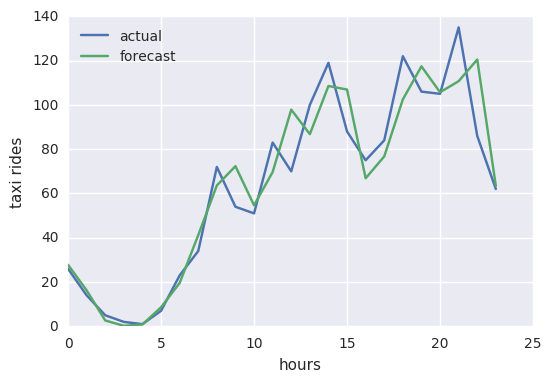

<function __main__.fig>

In [8]:
# shift - часовой лаг прогноза
interact(fig, shift=(1,6,1), region=regions, date=dates)

### Статическая карта с визуализацией реального и прогнозируемого спроса на такси в выбираемый момент времени

In [9]:
map_types=['actual','forecast','delta(a-f)']
map_dict={'actual':'true','forecast':'y','delta(a-f)':'delta'}

In [12]:
def map_fig(shift=1, map_type='forecast', hour=0):
    date = datetime.date(2016, 6, 1) + relativedelta(hour=int(hour)%24, days=int(hour)//24)
    print 'Date-time: ', date
    col_names=['region',map_dict[map_type]]
    r=result[result['shift']==int(shift)].shift(int(shift))
    r=r[r.index==date]
    zones=np.zeros((50,50))
    for i in r[col_names].as_matrix():
        zones[int(i[0])%50,int(i[0])//50]=i[1]
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    m = Basemap(resolution=None,llcrnrlat=40.49612,urcrnrlat=40.91553,llcrnrlon=-74.25559,urcrnrlon=-73.70001)
    m.arcgisimage(xpixels = 400, dpi=96, verbose=False)
    ny = zones.shape[0]; nx = zones.shape[1]
    lons, lats = m.makegrid(nx, ny) 
    x, y = m(lons, lats)
    levels=5
    step=zones.max()//levels
    clevs = [1+n*step for n in range(levels)]
    cs = m.contourf(x,y,zones,clevs,alpha=0.8, cmap='plasma')
    cbar = m.colorbar(cs,location='bottom',pad="5%")
    plt.show()

Date-time:  2016-06-01 00:00:00


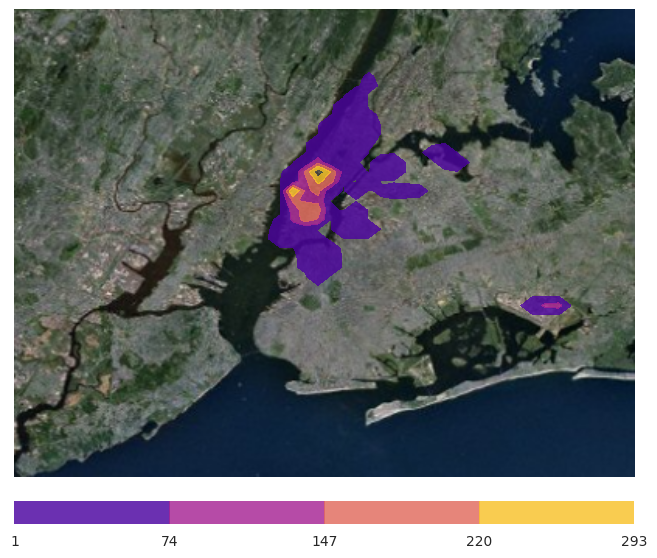

<function __main__.map_fig>

In [11]:
interact(map_fig, shift=(1,6,1), map_type=map_types, hour=(0,713,1))

### Динамическая карта с визуализацией реального и прогнозируемого спроса на такси в выбираемый момент времени

In [13]:
#координаты ячеек
regions=pd.read_csv('regions.csv', sep=";")

In [14]:
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [15]:
ind=result.index
result=pd.merge(result, regions, how='left')
result.index=ind

In [16]:
result.head()

,true,region,shift,y,delta,west,east,south,north
2016-05-31 23:00:00,26.0,1075,1,27.784430,-1.784430,-74.022246,-74.011135,40.697437,40.705825
2016-05-31 23:00:00,30.0,1076,1,40.380908,-10.380908,-74.022246,-74.011135,40.705825,40.714213
2016-05-31 23:00:00,19.0,1077,1,16.308441,2.691559,-74.022246,-74.011135,40.714213,40.722601
2016-05-31 23:00:00,39.0,1125,1,25.857799,13.142201,-74.011135,-74.000023,40.697437,40.705825
2016-05-31 23:00:00,71.0,1126,1,80.286590,-9.286590,-74.011135,-74.000023,40.705825,40.714213


In [17]:
map_dict_new={'actual':0,'forecast':3,'delta(a-f)':4}

In [19]:
west, south, east, north = -74.25559, 40.49612, -73.70001, 40.91553

In [22]:
def d_map_fig(shift=1, map_type='forecast', hour=0):
    
    date = datetime.date(2016, 6, 1) + relativedelta(hour=int(hour)%24, days=int(hour)//24)
    print 'Date-time: ', date
    r=result[result['shift']==int(shift)].shift(int(shift))
    r=r[r.index==date]

    with open('week7_regions.json','w') as file_obj:
        file_obj.write('{"type":"FeatureCollection","features":['+'\n')

    for i in r.as_matrix():
        a='{"type":"Feature","id":'+str(int(i[1]))+',"properties":{"name":"id'+str(int(i[1]))+'","num":'+\
        str(i[map_dict_new[map_type]])+'},"geometry":{"type":"Polygon","coordinates":[[['+str(i[5])+','+str(i[8])+'],['+\
        str(i[6])+','+str(i[8])+'],['+str(i[6])+','+str(i[7])+'],['+str(i[5])+','+str(i[7])+'],['+str(i[5])+','+str(i[8])+']]]}},'
    
        if i[1]==r.region.values[-1:][0]:
            with open('week7_regions.json','a') as file_obj:
                file_obj.write(a[:-1]+'\n')
        else:
            with open('week7_regions.json','a') as file_obj:
                file_obj.write(a+'\n')
        
    with open('week7_regions.json','a') as file_obj:
        file_obj.write(']}')
        
    geo = r'week7_regions.json'

    map = folium.Map(location=[(south+north)/2, (east+west)/2], zoom_start=10)
    folium.Marker(location=[40.689167,-74.044444], popup='Liberty Enlightening the World').add_to(map)
    map.choropleth(geo_path=geo, data=r,
             columns=['region', map_dict[map_type]],
             key_on='feature.id',
             fill_color='OrRd', fill_opacity=0.6, line_opacity=0.2,
             legend_name='Taxi rides')


    #map.save('week7_map.html')
    return map

In [23]:
interact(d_map_fig, shift=(1,6,1), map_type=map_types, hour=(0,713,1))

Date-time:  2016-06-01 00:00:00


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


<function __main__.d_map_fig>